# ⚡ **FocalCodec**

A low-bitrate single-codebook 16 / 24 kHz speech codec based on [focal modulation](https://arxiv.org/abs/2203.11926).

- 📜 **Preprints**:
    
    - [FocalCodec: Low-Bitrate Speech Coding via Focal Modulation Networks](https://arxiv.org/abs/2502.04465)

    - [FocalCodec-Stream: Streaming Low-Bitrate Speech Coding via Causal Distillation](https://arxiv.org/abs/2509.16195)

- 🌐 **Project Page**: https://lucadellalib.github.io/focalcodec-web/

- 🔊 **Downstream Tasks**: https://github.com/lucadellalib/audiocodecs


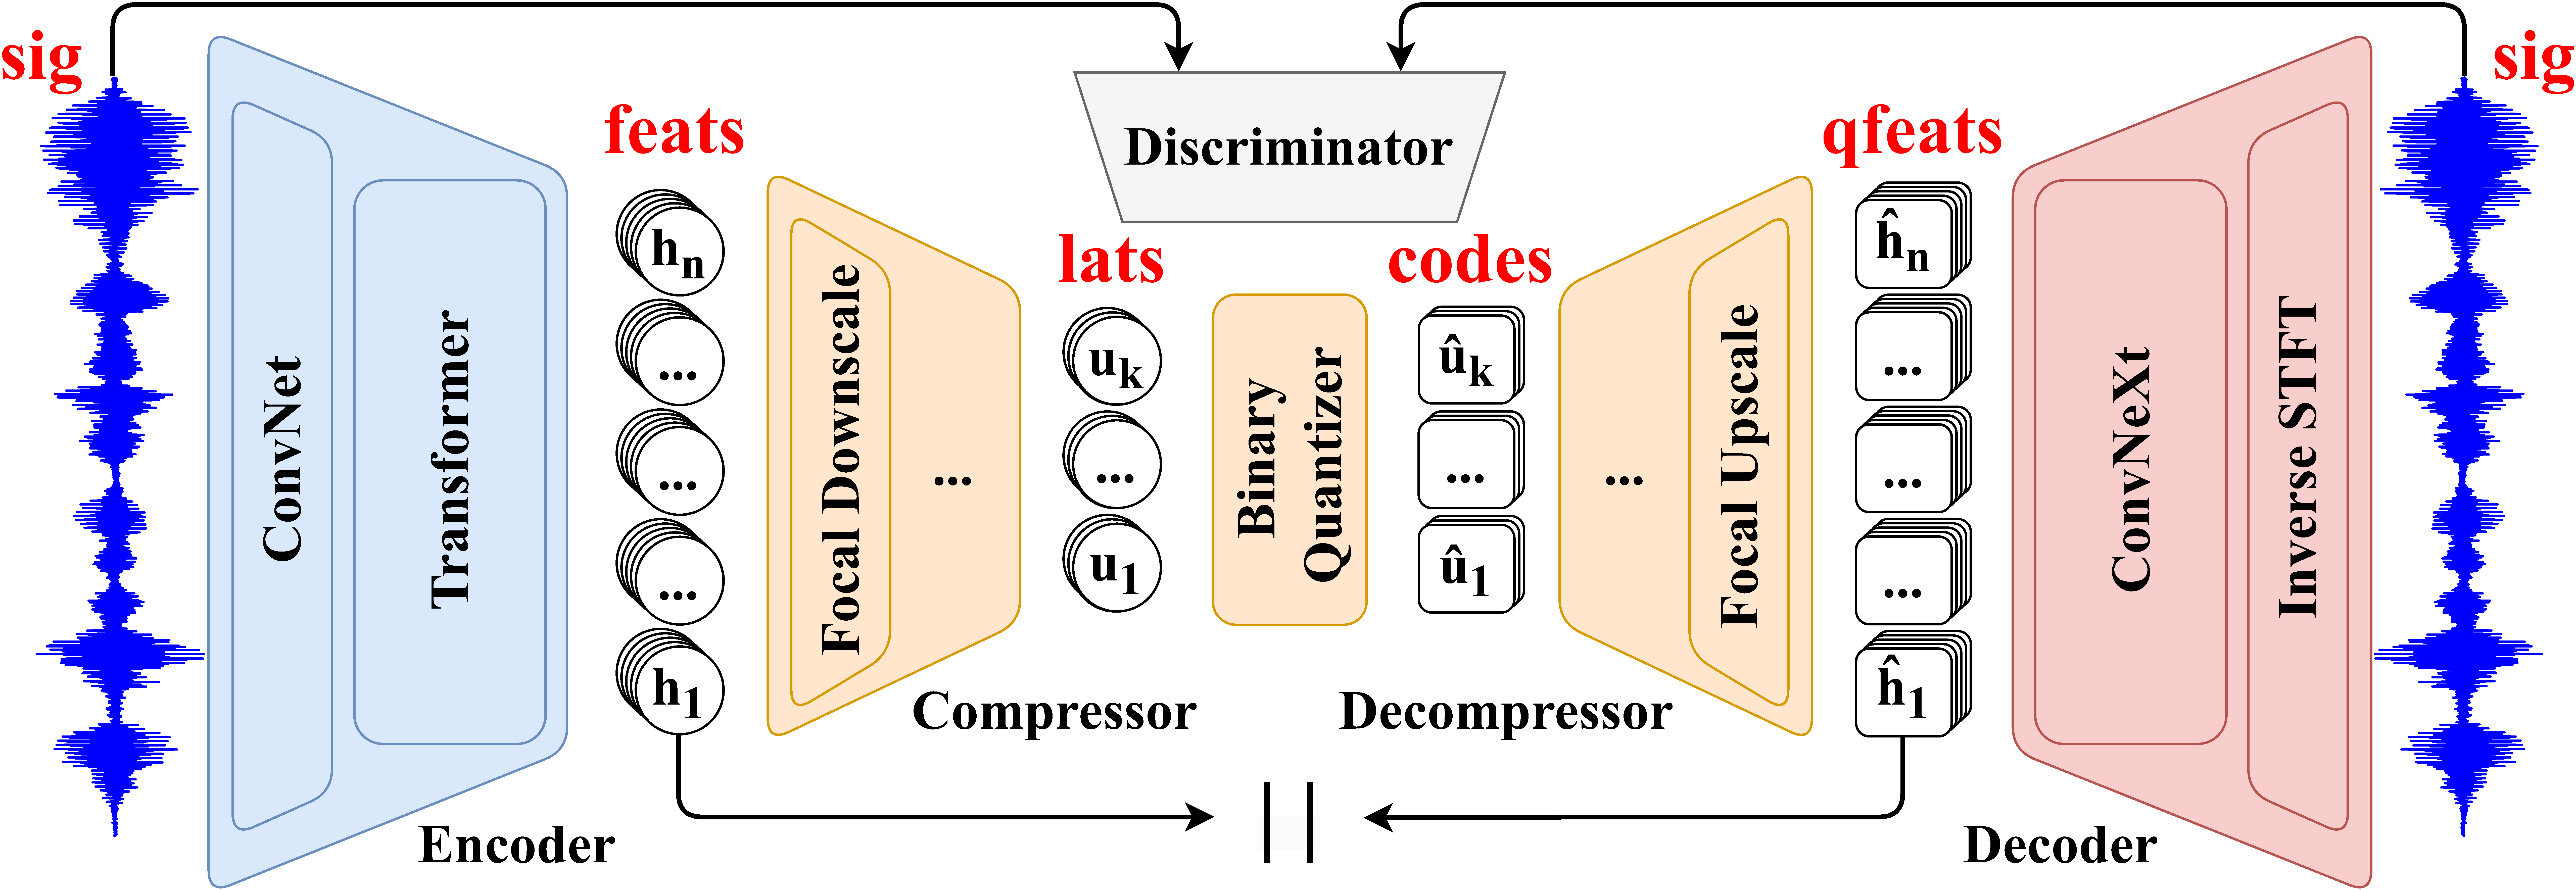

## 📖 **API Overview**

FocalCodec provides a unified interface for **transforming between different audio representations**.  
At its core, every transformation follows the naming convention:

```python
def <input>_to_<output>(*args, **kwargs):
  ...
```

**`<input>`** can be:
  - **`sig`**: raw waveform
  - **`feats`**: continuous features
  - **`lats`**: continuous latents
  - **`codes`**: quantized latents
  - **`toks`**: token indices (each code corresponds to a token)

**`<output>`** can be:
  - **`sig`**: raw waveform
  - **`qfeats`**: quantized features
  - **`lats`**: continuous latents
  - **`codes`**: quantized latents
  - **`toks`**: token indices (each code corresponds to a token)

The **`forward`** method is a thin wrapper around **`sig_to_sig`**. It takes a waveform as input and returns the corresponding tokens, codes, and reconstructed waveform.

Each method expects tensors with leading dimensions for **batch** and **sequence**.  

For example, to perform a **Signal → Codes → Signal** transformation:

```python
sig = torch.randn(B, T)              # Waveform input: (batch, time)
codes = codec.sig_to_codes(sig)      # Discrete codes: (batch, code_time, code_dim)
rec_sig = codec.codes_to_sig(codes)  # Reconstructed waveform: (batch, time)
```

Additional methods:

- **`info`**: return the model information
- **`jit`**: JIT compile the model
- **`onnx`**: export the model to ONNX format
- **`to_config`**: dump model configuration
- **`to_pretrained`**: dump model configuration and weights

## ⚡ **Streaming Usage**

FocalCodec follows a **stateless design**, which makes switching to streaming mode straightforward and requires only minimal changes.

Conceptually, you can think of it like an RNN: each transformation consumes an input and a state, and produces an output along with an updated state.
By default, the state is initialized as empty and the updated state is not returned, keeping the API plug-and-play for existing pipelines.
You can return it by setting `return_state=True`.

For example, to perform a **Signal → Codes → Signal** transformation in a streaming fashion:

```python
chunk_size = codec.chunk_size                             # Chunk size for streaming
sig_to_codes_state, codes_to_sig_state = [], []           # Streaming states for each transformation
while True:
    sig_i = torch.randn(B, chunk_size)                    # Waveform input: (batch, chunk_size)
    codes_i, *sig_to_codes_state = codec.sig_to_codes(    # Discrete codes: (batch, code_chunk_size, code_dim)
      sig_i, *sig_to_codes_state, return_state=True,
    )
    rec_sig_i, *codes_to_sig_state = codec.codes_to_sig(  # Reconstructed waveform: (batch, chunk_size)
      codes_i, *codes_to_sig_state, return_state=True,
    )
```

⚠️ **WARNING**: streaming is supported only for **causal checkpoints**, such as [lucadellalib/focalcodec_50hz_4k_causal](https://huggingface.co/lucadellalib/focalcodec_50hz_4k_causal). Using this streaming template with a non-causal checkpoint such as [lucadellalib/focalcodec_50hz](https://huggingface.co/lucadellalib/focalcodec_50hz) will produce invalid output.

# 🎤 **Running the Demo**

**NOTE**: Colab does not support real-time audio streaming. For live streaming on your local machine, please follow [these instructions](https://github.com/lucadellalib/focalcodec/tree/main?tab=readme-ov-file#-running-the-demo).

In [ ]:
# Download the repository and install the requirements
%%capture
!rm -rf focalcodec
!git clone https://github.com/lucadellalib/focalcodec.git
%cd focalcodec
!sudo apt-get install libportaudio2
!pip install huggingface-hub safetensors sounddevice soundfile torch torchaudio

## **Speech Resynthesis**

In [ ]:
# Available default configurations:
# "lucadellalib/focalcodec_50hz"
# "lucadellalib/focalcodec_50hz_65k_causal"
# "lucadellalib/focalcodec_50hz_4k_causal"
# "lucadellalib/focalcodec_50hz_2k_causal"
# "lucadellalib/focalcodec_25hz"
# "lucadellalib/focalcodec_12_5hz"

input_file = "audios/librispeech-dev-clean/251-118436-0003.wav"
output_file = "reconstruction.wav"
config = "lucadellalib/focalcodec_50hz"

!python demo.py \
    {input_file} \
    --output-file {output_file} \
    --config {config}

from IPython.display import HTML, Audio
display(HTML("<b>Original:</b>"), Audio(input_file))
display(HTML("<b>Reconstruction:</b>"), Audio(output_file))

## **Voice Conversion**

In [ ]:
# Available default configurations:
# "lucadellalib/focalcodec_50hz"
# "lucadellalib/focalcodec_50hz_65k_causal"
# "lucadellalib/focalcodec_50hz_4k_causal"
# "lucadellalib/focalcodec_50hz_2k_causal"
# "lucadellalib/focalcodec_25hz"
# "lucadellalib/focalcodec_12_5hz"

input_file = "audios/librispeech-dev-clean/251-118436-0003.wav"
output_file = "reconstruction.wav"
reference_file = "audios/librispeech-dev-clean/84/84-121123-0026.wav"
config = "lucadellalib/focalcodec_50hz"

!python demo.py \
    {input_file} \
    --output-file {output_file} \
    --reference-files {reference_file} \
    --config {config}

from IPython.display import HTML, Audio
display(HTML("<b>Original:</b>"), Audio(input_file))
display(HTML("<b>Target voice:</b>"), Audio(reference_file))
display(HTML("<b>Reconstruction:</b>"), Audio(output_file))